# SMAP soil moisture and GPM precipitation

## Author: Jacquelyn Witte

In [1]:
import os
from glob import glob

import datetime as dt
import earthpy as et
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import xarray as xr

import warnings
warnings.filterwarnings('ignore')

# Prettier plotting with seaborn
sns.set(font_scale=1.3, style="whitegrid")

In [2]:
def read_smap(filepath, index):
    """
    Reads SMAP data and returns the variable of interest.
    
    Parameters
    ----------
    filepath: Str
        File path of a SMAP L3 HDF5 file
        
    group_id: String
        Groups within the file to access
        
    index: int
        Index associated with the variable to retrieve
    
    Returns
    -------
    data: 2D numpy.ndarray (lat, lon)
    date: Date String yyyymmdd
    """
    # Read the file
    group_id = 'Soil_Moisture_Retrieval_Data_PM'
    with h5py.File(filepath, 'r') as f:
        # Extract data info
        data_id = list(f[group_id].keys())[index]
        data = f[group_id][data_id][:,:]
        data[data == f[group_id][data_id].attrs['_FillValue']] = np.nan
        
        filename = os.path.basename(filepath)
        yyyymmdd= filename.split('_')[5]
        yyyy = int(yyyymmdd[0:4])
        mm = int(yyyymmdd[4:6])
        dd = int(yyyymmdd[6:8])
        date=dt.datetime(yyyy,mm,dd)
    return data, date

#### Read and subset to Colorado Landslides >= year 2015

In [3]:
# Read the GLC file
glc_file = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone', 
                        'landslide', 'nasa_global_landslide_catalog_point.csv')

os.path.exists(glc_file)
glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                glc['admin_division_name'] == 'Colorado') & (
                glc['landslide_trigger'] != 'freeze_thaw') & (
                glc['landslide_trigger'] != 'snowfall_snowmelt') & (
                glc['landslide_trigger'] != 'no_apparent_trigger') & (
                glc['landslide_trigger'] != 'other') & (
                glc['landslide_trigger'] != 'unknown')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co_gt2015 = glc_co[glc_co.index > '2015-01-01']

print(glc_co_gt2015.shape)
print(np.unique(glc_co_gt2015['landslide_trigger']))
print(glc_co_gt2015.columns)

(39, 31)
['continuous_rain' 'downpour' 'rain']
Index(['OBJECTID', 'Shape', 'source_name', 'source_link', 'event_id',
       'event_date', 'event_time', 'event_title', 'event_description',
       'location_description', 'location_accuracy', 'landslide_category',
       'landslide_trigger', 'landslide_size', 'landslide_setting',
       'fatality_count', 'injury_count', 'storm_name', 'photo_link',
       'comments', 'event_import_source', 'event_import_id', 'latitude',
       'longitude', 'country_name', 'country_code', 'admin_division_name',
       'gazetteer_closest_point', 'gazetteer_distance', 'submitted_date',
       'last_edited_date'],
      dtype='object')


#### Get all SMAP and GLC data files, sorted

In [12]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data', 'capstone')
smap_files = sorted(glob(os.path.join(data_dir, 'smap_l2', '*.h5')))

gpm_files = sorted(glob(os.path.join(data_dir, 'gpm_old', '*nc4')))

print(smap_files[0:3])
print(gpm_files[0:3])

['/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20150331_R17000_002.h5', '/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20150401_R17000_002.h5', '/Users/jwitte/earth-analytics/data/capstone/smap_l2/SMAP_L3_SM_P_E_20150402_R17000_001.h5']
['/Users/jwitte/earth-analytics/data/capstone/gpm_old/3B-DAY-L.MS.MRG.3IMERG.20070101-S000000-E235959.V06.nc4.SUB.nc4', '/Users/jwitte/earth-analytics/data/capstone/gpm_old/3B-DAY-L.MS.MRG.3IMERG.20070102-S000000-E235959.V06.nc4.SUB.nc4', '/Users/jwitte/earth-analytics/data/capstone/gpm_old/3B-DAY-L.MS.MRG.3IMERG.20070103-S000000-E235959.V06.nc4.SUB.nc4']


#### These are the variables that will provide key information in characterizing landslides over Colorado

| Variable Name | Index | Units |
| ----------- | ----------- | ----------- |
| soil_moisture | 24 | cm<sup>3</sup>/cm<sup>3</sup> |
| surface_temperature | 31 | degC |
| radar_water_body_fraction | 15 | N/A | 
| vegetation_opacity | 46 | N/A |
| vegetation_water_content | 50 | kg/m<sup>2</sup> |

#### Load the EASE2 grid lon and lat datasets. These can be found on the NSIDC website.

In [6]:
# Reshape to dimensions of the SMAP data above
sm_data, date = read_smap(smap_files[1], 24)

lats = np.fromfile(os.path.join(data_dir, 'smap_l2', 'EASE2_M09km.lats.3856x1624x1.double'), 
                      dtype=np.float64).reshape(sm_data.shape)
lons = np.fromfile(os.path.join(data_dir, 'smap_l2', 'EASE2_M09km.lons.3856x1624x1.double'), 
                      dtype=np.float64).reshape(sm_data.shape)
sm_data.shape

(1624, 3856)

### Read the SMAP and GPM data 
- Colocated to all the Landslide events
- Collected measurements going back 7 day from each landslide event

In [17]:
sm_date = []
landslide_id = []
landslide_cat = []
landslide_trig = []
landslide_sz = []
lat = []
lon = []
periods = 7
count_down = []
sm_mean = []
sfct_mean = []
vegop_mean = []
vegwc_mean = []
precip = []

for i, ls_date in enumerate(glc_co_gt2015.index[1:len(glc_co_gt2015.index)]):
    
    # Get -7 days from the event
    glc_date = pd.date_range(ls_date, periods=periods,
                         freq='-1D').strftime('%Y%m%d')
    #print(i, ls_date)
    countd = periods
    
    # Take the +/- 0.3 deg mean around the Landslide event
    N_lat = glc_co_gt2015.latitude[i]+0.15
    S_lat = glc_co_gt2015.latitude[i]-0.15
    W_lon = glc_co_gt2015.longitude[i]-0.15
    E_lon = glc_co_gt2015.longitude[i]+0.15
       
    subset = (lats < N_lat) & (lats > S_lat) & (lons > W_lon) & (lons < E_lon)
    
    # loop over the 7 days
    for dd in glc_date:
        # Find the SMAP file
        filesm = [x for x in smap_files if re.findall(dd, x)]
        # Retrieve the SMAP variables
        sm, time_t = read_smap(filesm[0], 24)
        #sfct, t = read_smap(filesm[0], 31)
        vegop, t = read_smap(filesm[0], 46)
        vegwc, t = read_smap(filesm[0], 50)
        
        # Calculate the SMAP mean
        sm_mean.append(np.nanmean(sm[subset]))
        #sfct_mean.append(np.nanmean(sfct[subset]))
        vegop_mean.append(np.nanmean(vegop[subset]))
        vegwc_mean.append(np.nanmean(vegwc[subset]))
        
        # find the GPM file 
        file = [x for x in gpm_files if re.findall(dd, x)]
        
        # read the GPM file
        data_xr = xr.open_dataset(file[0]).squeeze()
        
        # subset and append the GPM file
        res = data_xr['precipitationCal'].sel(indexers={
                    'lon': glc_co_gt2015.longitude[i],
                    'lat': glc_co_gt2015.latitude[i]},
                    method="nearest")
        precip.append(float(res.values))
        
        # Append the time
        sm_date.append(time_t)
        
        # Append landslide metadata
        lat.append(glc_co_gt2015.latitude[i])
        lon.append(glc_co_gt2015.longitude[i])
        landslide_id.append(glc_co_gt2015.event_id[i])
        landslide_cat.append(glc_co_gt2015.landslide_category[i])
        landslide_trig.append(glc_co_gt2015.landslide_trigger[i])
        landslide_sz.append(glc_co_gt2015.landslide_size[i])
    
        # Append countdown
        count_down.append(countd)
        countd -=1

# Create a pandas series
landslide_df = pd.DataFrame(sm_mean, 
                      index= pd.to_datetime(sm_date), columns=['smap_sm'])
landslide_df['veg_opacity'] = vegop_mean
landslide_df['veg_water_content'] = vegwc_mean
landslide_df['precip_mm'] = precip

# Add the Landslide metadata
#landslide_df['surface_temperature'] = sfct_mean
#landslide_df['surface_temperature'] = soilm_df['surface_temperature'] - 273.15
landslide_df['glc_lat'] = lat
landslide_df['glc_lon'] = lon
landslide_df['landslide_id'] = landslide_id
landslide_df['landslide_category'] = landslide_cat
landslide_df['landslide_trigger'] = landslide_trig
landslide_df['landslide_size'] = landslide_sz
landslide_df['days-to-landslide'] = count_down

# Calculated the cumulative precipitation
accum = []
for i, data in landslide_df.groupby("landslide_id"):
    accum.extend(np.flip(data['precip_mm'].cumsum().values))
landslide_df['precip_accum_mm'] = accum

In [18]:
landslide_df.head()

,smap_sm,veg_opacity,veg_water_content,precip_mm,glc_lat,glc_lon,landslide_id,landslide_category,landslide_trigger,landslide_size,days-to-landslide,precip_accum_mm
2015-05-11,NaN,NaN,NaN,0.002020,40.4802,-106.8393,6994,landslide,continuous_rain,medium,7,17.994297
2015-05-10,NaN,NaN,4.308795,1.668476,40.4802,-106.8393,6994,landslide,continuous_rain,medium,6,17.994297
2015-05-09,NaN,NaN,NaN,9.146796,40.4802,-106.8393,6994,landslide,continuous_rain,medium,5,5.680695
2015-05-08,0.237144,0.240331,2.819524,4.127171,40.4802,-106.8393,6994,landslide,continuous_rain,medium,4,3.924306
2015-05-07,0.275654,0.327607,4.257044,1.503280,40.4802,-106.8393,6994,landslide,continuous_rain,medium,3,3.260700


### Plot soil time series going back 7 days from each co-located Landslide

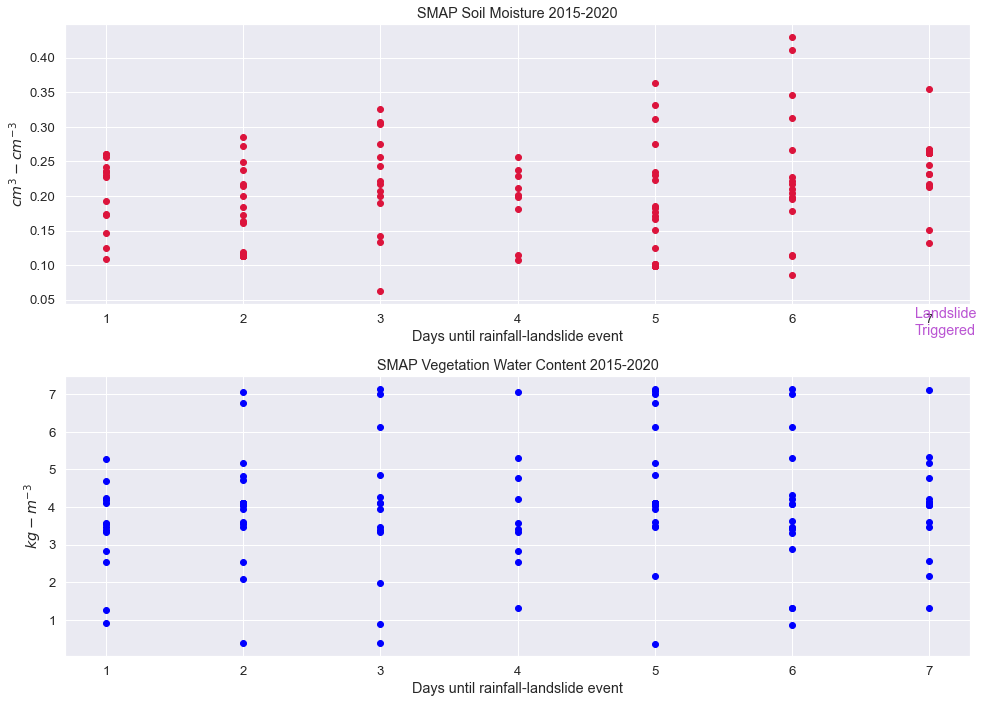

In [20]:
sns.set(font_scale=1.2)
#sns.set(font_scale=1.2, style="whitegrid")

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

for id, df in landslide_df.groupby("landslide_id"):
    ax1.plot(df['days-to-landslide'], df['smap_sm'],
            marker='o', linestyle='none', color='crimson')

ax1.set(xlabel='Days until rainfall-landslide event',
       ylabel='$cm^3 - cm^{-3}$',
       title='SMAP Soil Moisture 2015-2020')

ax1.text(6.9, 0.0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

for id, df in landslide_df.groupby("landslide_id"):
    ax2.plot(df['days-to-landslide'], df['veg_water_content'],
            marker='o', linestyle='none', color='blue')

ax2.set(xlabel='Days until rainfall-landslide event',
       ylabel='$kg-m^{-3}$',
       title='SMAP Vegetation Water Content 2015-2020')



plt.tight_layout()
plt.savefig(os.path.join(et.io.HOME,
            'earth-analytics',
            'capstone-landslides-soilmoisture', 'plots',
            'smap_soilmoisture_timeseries.png'))

### Plot the cumulative precipitation going back 7 days

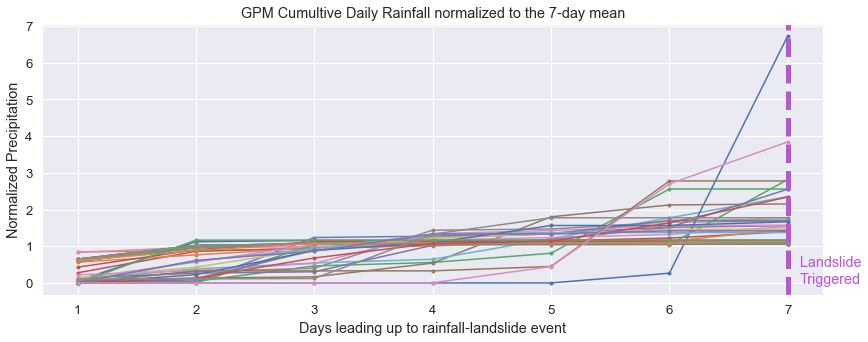

In [23]:
fig, ax = plt.subplots(figsize=(14, 5), sharex=True, sharey=True)

for id, df in landslide_df.groupby("landslide_id"):
    ax.plot(df['days-to-landslide'], 
            df['precip_accum_mm']/df['precip_accum_mm'].mean(), 
            marker='.')

#ax.invert_xaxis()
ax.axvline(x=7, ymin=0, color='mediumorchid', linestyle='dashed', linewidth=5)
#ax.set_xlim([-30,-0.5])
ax.set(xlabel='Days leading up to rainfall-landslide event',
       ylabel='Normalized Precipitation',
       title='GPM Cumultive Daily Rainfall normalized to the 7-day mean')
ax.text(7.1 ,0, 'Landslide\nTriggered', color='mediumorchid', fontsize='medium');

### Plot Precipitation vs Soil Moisture

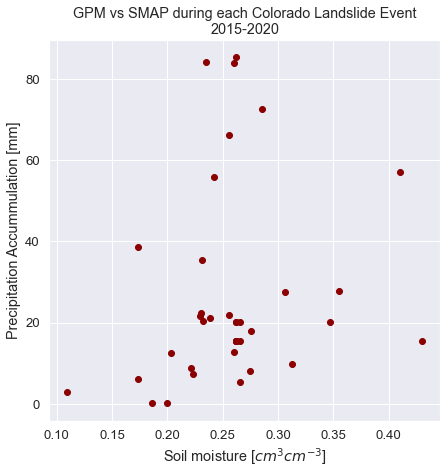

In [30]:
# Create a scatter plot
sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(7, 7))

for id, df in landslide_df.groupby("landslide_id"):
    ax.scatter(df['smap_sm'].max(), df['precip_accum_mm'].max(),
           color='darkred')

ax.set(xlabel='Soil moisture [$cm^3 cm^{-3}$]',
       ylabel='Precipitation Accummulation [mm]',
      title='GPM vs SMAP during each Colorado Landslide Event\n2015-2020');